In [1]:
#!pip install dask==2023.3.2
#!pip install dask==2024.2.0
#!pip install bokeh==2.4.2
#!pip install bokeh==2.4.3
#!pip install bokeh==3.3.4
#!pip install FuzzyTM blosc2 cython requests_mock pyqt5 pyqtwebengine
#!pip install numpy==1.23
#!pip install black==22.3.0
#!pip install clyent==1.2.1
#!pip install jedi==0.17.2
#!pip install blosc2==2.0.0

!pip install git+https://github.com/OSOceanAcoustics/echoshader.git
!pip install -r echoshader_requirements.txt
import shutil
import traceback
import json
import os
import numpy as np
import echopype as ep
from importlib.metadata import version
from dask import delayed
from dask.utils import memory_repr
import dask

  Cloning https://github.com/OSOceanAcoustics/echoshader.git to /tmp/pip-req-build-_iacvdo9
  Running command git clone --filter=blob:none --quiet https://github.com/OSOceanAcoustics/echoshader.git /tmp/pip-req-build-_iacvdo9
  Resolved https://github.com/OSOceanAcoustics/echoshader.git to commit 9bcf22d8de93533101314085c0310bb73119b093
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
from pathlib import Path
import itertools as it
import bokeh
import datetime as dt
from dateutil import parser as dtparser
import pandas as pd
import fsspec
import xarray as xr
import matplotlib.pyplot as plt
import hvplot.xarray
import csv
import echopype as ep
import os
import warnings
from echopype import open_raw
import dask
from dask.distributed import Client, LocalCluster, performance_report
import traceback

from tqdm import tqdm
import requests
from datetime import datetime
from dateutil import parser as dtparser
from urllib.parse import urljoin
from datetime import timedelta


warnings.simplefilter("ignore", category=DeprecationWarning)
fs = fsspec.filesystem('https')

In [3]:
version('dask')

'2024.2.1'

In [4]:
version('bokeh')

'3.3.4'

# Creating Local Cluster for Dask

In [5]:
#cluster = LocalCluster()
#client = Client(cluster)
client = Client(processes=False)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://10.1.22.254:8787/status,
Dashboard: http://10.1.22.254:8787/status,Workers: 1
Total threads: 64,Total memory: 245.77 GiB
Status: running,Using processes: False
Comm: inproc://10.1.22.254/39294/1,Workers: 1
Dashboard: http://10.1.22.254:8787/status,Total threads: 64
Started: Just now,Total memory: 245.77 GiB
Comm: inproc://10.1.22.254/39294/4,Total threads: 64
Dashboard: http://10.1.22.254:40917/status,Memory: 245.77 GiB
Nanny: None,


open and save
open and save
open and save
open and save
open and save
open and save
open and save
open and save
open and save
open and save
open and save
open and save
open and save
open and save
open and save
open and save


In [6]:
fs = fsspec.filesystem('https')
base_dpath = Path('./exports')
base_dpath.mkdir(exist_ok=True)

# Create a directory for all files
output_dpath = Path(base_dpath / 'ooimooring_allfiles')
output_dpath.mkdir(exist_ok=True)


# Enter URL for the Instrument

In [7]:
ooi_raw_url = "https://rawdata.oceanobservatories.org/files/CE04OSPS/PC01B/ZPLSCB102_10.33.10.143/"

In [8]:
def parse_exception(exception):
    exc_dict = {
        'type': type(exception).__name__,
        'value': str(exception),
        'traceback': "".join(
            traceback.format_exception(
                type(exception), exception, exception.__traceback__
            )
        ),
    }
    return exc_dict

# Checking if the file fetched is within the start time and end time

In [9]:
def in_range(raw_file: str, start: datetime, end: datetime) -> bool:
    file_name = Path(raw_file).name
    
    if 'OOI-' in file_name:
        format_string = "OOI-D%Y%m%d-T%H%M%S.raw"
        file_datetime = datetime.strptime(file_name, format_string)
        return start <= file_datetime <= end

    return False

# Enter start time and end time

In [10]:
start_datetime = dt.datetime(2017, 8, 21, 0, 0)
end_datetime = dt.datetime(2017, 8, 22, 0, 0)

# Create all possible URLs between start time and end time

In [11]:
desired_day_urls = []
current_date = start_datetime

while current_date <= end_datetime:
    day_url = urljoin(
        ooi_raw_url,
        f"{current_date.year}/{current_date.month:02d}/{current_date.day:02d}"
    )
    desired_day_urls.append(day_url)
    current_date += timedelta(days=1)

# Fetching from the URLs created and checking if the URL is valid and a raw file is present on that URL

In [12]:
all_raw_file_urls = it.chain.from_iterable([fs.glob(f"{day_url}/*.raw") for day_url in tqdm(desired_day_urls) if  requests.get(day_url).status_code ==200 ])

100%|█████████████████████████████████████████████| 2/2 [00:02<00:00,  1.15s/it]


# Calculating Number of raw files 

In [13]:
desired_raw_file_urls = list(filter(
    lambda raw_file: in_range(
        raw_file,
        start_datetime-dt.timedelta(hours=0),  # 3 hour buffer to select files
        end_datetime+dt.timedelta(hours=0)
    ),
    all_raw_file_urls
))
print(f"There are {len(desired_raw_file_urls)} raw files within the specified datetime range.")

There are 16 raw files within the specified datetime range.


# Function to fetch information from the raw file on the URL

### Uncomment the to_zarr line to store intermediate echodata objects

In [14]:

def open_and_save(raw_file, sonar_model, use_swap, save_path, open_kwargs={}, save_kwargs={}):
    try:
        print('open and save')
        ed = ep.open_raw(raw_file=raw_file, sonar_model=sonar_model, use_swap=use_swap, **open_kwargs)
        #ed.to_zarr(save_path=save_path, overwrite=True)
        return ed
    except Exception as e:
        print('exception')
        exc_dict = parse_exception(e)
        print("Error with Exception: ", e)

# Submitting all the urls with raw files in the dask queue

In [15]:
def get_ed_list(desired_raw_file_urls):
    ed_list = []
    paths = []
    for raw_file_url in tqdm(desired_raw_file_urls):
        ed = client.submit(open_and_save,
                       raw_file=raw_file_url,
                       sonar_model='ek60',
                       use_swap=True,
                       save_path=output_dpath 
                       )
        ed_list.append(ed)
        paths.append(str(raw_file_url))
    return ed_list, paths

# Checking all possible unique years and creating a dataframe to store the path for each raw file

In [16]:
def create_year_dataframe(final_df):
    df = pd.DataFrame()
    count =0
    t = []
    for index,row in final_df.iterrows():
        df.at[count, 'Echodata_object'] = row['Echodata']
        df.at[count, 'Path'] = str(row['Object_Name'])
        df.at[count, 'Year'] = str(row['Object_Name'].split('/')[-1].split('-')[1].split('D')[1][0:4])
        df.at[count, 'Month'] = str(row['Object_Name'].split('/')[-1].split('-')[1].split('D')[1][4:6])
        channels = list(row['Echodata'].platform.channel.to_pandas())
        df.at[count, 'Channel1'] = channels[0]
        df.at[count, 'Channel2'] = channels[1]
        df.at[count, 'Channel3'] = channels[2]
        count = count +1

    print(df.shape)
    return df

# Checking year dataframe

In [17]:
year_df = pd.DataFrame()
year_df['Year'] = [i.split('/')[-1].split('-')[1].split('D')[1][0:4] for i in desired_raw_file_urls]
year_df['Url'] = desired_raw_file_urls
print(year_df.shape)
year_df.head(2)

(16, 2)


,Year,Url
0,2017,https://rawdata.oceanobservatories.org/files/C...
1,2017,https://rawdata.oceanobservatories.org/files/C...


# Function which iterates through each year, each channel within each year and creates combined echodata objects based on the channels

In [18]:
%%time
import warnings
warnings.simplefilter('ignore')
years =list(year_df.Year.unique())
print(years)
batch_size = 50
local_obj = None

fs_local = fsspec.filesystem('file')
prefix = "echo_object"
count =0
final_dict = {}
for year in years:
    print("Year :" ,year)
    year_wise_url_list = year_df.loc[year_df['Year']==year]['Url']
    ed_list, paths = get_ed_list(year_wise_url_list)
    list_of_ed = client.gather(ed_list)
    print('Done')
    ed_list = list_of_ed
    ed_df = pd.DataFrame()
    ed_df['Echodata'] = ed_list
    ed_df['Object_Name'] = paths
    print(ed_df.shape)
    final_df = ed_df.dropna(axis =0)
    print(final_df.shape)
    df = create_year_dataframe(final_df)
    print('Dataframe for ', year, 'is', df.shape)
    channel_list = list(df.loc[df.Year == year]['Channel1'].value_counts().reset_index()['index'])
    print(channel_list)
    for channel in channel_list:
        print('Channel',channel)
        ed_lists = list(df.loc[(df['Year'] == year) & (df['Channel1'] == channel)]['Echodata_object'])
        ed = ed_lists
        print('Number of echodata objects with this channel in year ',year, 'are ', len(ed_lists))
        try:
            while len(ed) > 1 :
                if len(ed) <= batch_size :
                    print(len(ed))
                    final_ed = ep.combine_echodata(ed)
                    break
                    
                batches = [ed[i:i + batch_size] for i in range(0, len(ed), batch_size)]
                ed = [ep.combine_echodata(batch) for batch in tqdm(batches)]

            combined_ed_list = final_ed
        except Exception as e:
            print('Error with Exception:', e)
        
        final_dict["".join([prefix,'_',year,'_',channel])] = combined_ed_list
        count+=1

['2017']
Year : 2017


100%|██████████████████████████████████████████| 16/16 [00:00<00:00, 764.15it/s]


Done
(16, 2)
(16, 2)
(16, 7)
Dataframe for  2017 is (16, 7)
['GPT  38 kHz 00907208dd13 5-1 OOI.38|200']
Channel GPT  38 kHz 00907208dd13 5-1 OOI.38|200
Number of echodata objects with this channel in year  2017 are  16
16
CPU times: user 18.8 s, sys: 10.2 s, total: 29 s
Wall time: 18.8 s


# Final Dictionary gets created where the key is a combination of year and channel and the value is the combined echodata object

In [19]:
final_dict

{'echo_object_2017_GPT  38 kHz 00907208dd13 5-1 OOI.38|200': <EchoData: standardized raw data from Internal Memory>
 Top-level: contains metadata about the SONAR-netCDF4 file format.
 ├── Environment: contains information relevant to acoustic propagation through water.
 ├── Platform: contains information about the platform on which the sonar is installed.
 │   └── NMEA: contains information specific to the NMEA protocol.
 ├── Provenance: contains metadata about how the SONAR-netCDF4 version of the data were obtained.
 ├── Sonar: contains sonar system metadata and sonar beam groups.
 │   └── Beam_group1: contains backscatter power (uncalibrated) and other beam or channel-specific data, including split-beam angle data when they exist.
 └── Vendor_specific: contains vendor-specific information about the sonar and the data.}

In [20]:
final_dict.keys()

dict_keys(['echo_object_2017_GPT  38 kHz 00907208dd13 5-1 OOI.38|200'])

# Initial Visualization

## Checking size of combined echodata object for a specific key in the dictionary

In [21]:
echodata = final_dict['echo_object_2017_GPT  38 kHz 00907208dd13 5-1 OOI.38|200']
print(f"Echodata size: {memory_repr(echodata.nbytes)}")
#client.close()

Echodata size: 6.6 GB


print(version('msgpack'))
!pip install --upgrade msgpack==1.0.5
print(version('msgpack'))
client.close()

In [22]:
echodata

<EchoData: standardized raw data from Internal Memory>
Top-level: contains metadata about the SONAR-netCDF4 file format.
├── Environment: contains information relevant to acoustic propagation through water.
├── Platform: contains information about the platform on which the sonar is installed.
│   └── NMEA: contains information specific to the NMEA protocol.
├── Provenance: contains metadata about how the SONAR-netCDF4 version of the data were obtained.
├── Sonar: contains sonar system metadata and sonar beam groups.
│   └── Beam_group1: contains backscatter power (uncalibrated) and other beam or channel-specific data, including split-beam angle data when they exist.
└── Vendor_specific: contains vendor-specific information about the sonar and the data.

# Computing compute_sv on the combined echodata object

In [23]:
ds_Sv = ep.calibrate.compute_Sv(echodata)
ds_Sv

<xarray.Dataset> Size: 5GB
Dimensions:                        (channel: 3, ping_time: 91714,
                                    range_sample: 1072, filenames: 1)
Coordinates:
  * channel                        (channel) <U39 468B 'GPT  38 kHz 00907208d...
  * ping_time                      (ping_time) datetime64[ns] 734kB 2017-08-2...
  * range_sample                   (range_sample) int64 9kB 0 1 2 ... 1070 1071
  * filenames                      (filenames) int64 8B 0
Data variables: (12/16)
    Sv                             (channel, ping_time, range_sample) float64 2GB dask.array<chunksize=(1, 5924, 1072), meta=np.ndarray>
    echo_range                     (channel, ping_time, range_sample) float64 2GB dask.array<chunksize=(1, 5924, 1072), meta=np.ndarray>
    frequency_nominal              (channel) float64 24B 3.8e+04 1.2e+05 2e+05
    sound_speed                    (channel, ping_time) float64 2MB 1.494e+03...
    sound_absorption               (channel, ping_time) float64 2MB 0.009785 ...
    sa_correction                  (ping_time, channel) float64 2MB 0.0 ... 0.0
    ...                             ...
    angle_sensitivity_alongship    (channel) float64 24B 21.9 23.0 23.0
    angle_sensitivity_athwartship  (channel) float64 24B 21.9 23.0 23.0
    beamwidth_alongship            (channel) float64 24B 7.1 7.0 7.0
    beamwidth_athwartship          (channel) float64 24B 7.1 7.0 7.0
    source_filenames               (filenames) <U26 104B 'SOURCE FILE NOT IDE...
    water_level                    float64 8B 0.0
Attributes:
    processing_software_name:     echopype
    processing_software_version:  0.8.3
    processing_time:              2024-03-11T18:07:30Z
    processing_function:          calibrate.compute_Sv

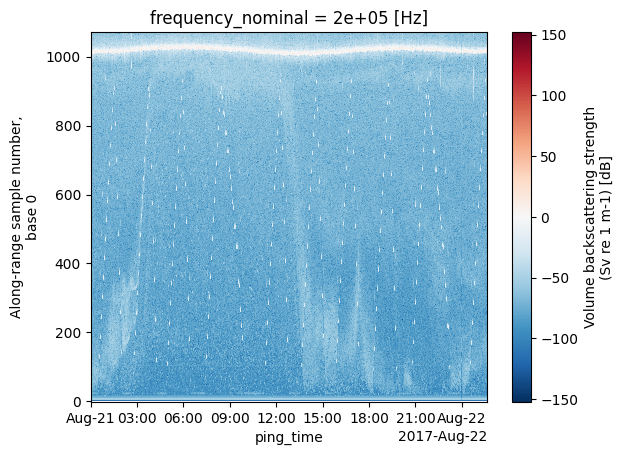

In [45]:
ds_Sv = ep.consolidate.swap_dims_channel_frequency(ds_Sv)
ds_Sv= ds_Sv.sortby('ping_time')
ds_Sv.Sv.sel(frequency_nominal=200000).plot(x='ping_time')

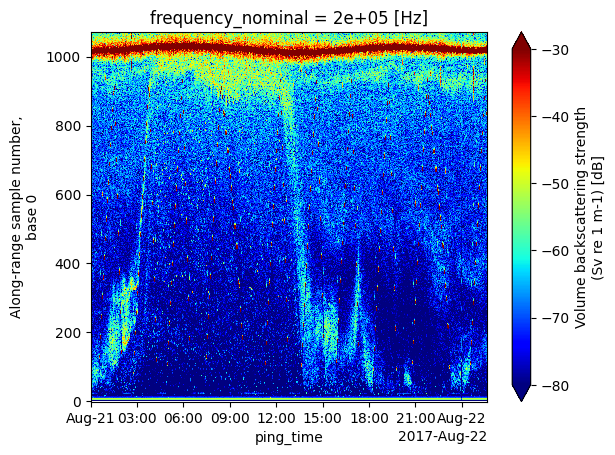

In [46]:
ds_Sv.Sv.sel(frequency_nominal=200000).plot.pcolormesh(
    x='ping_time', cmap = 'jet', vmin=-80, vmax=-30
);

In [47]:
import echopype.visualize as epviz
import echopype as ep

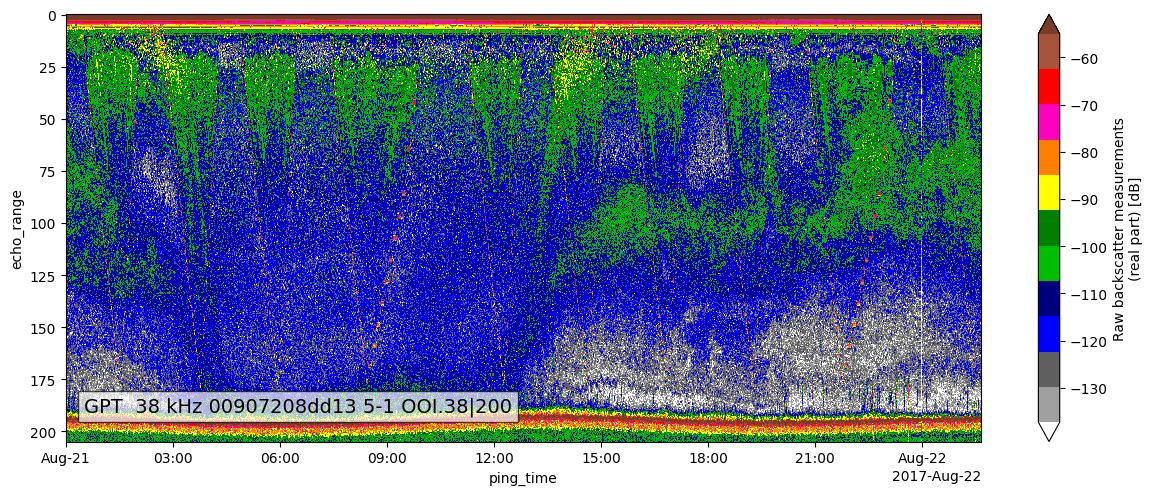

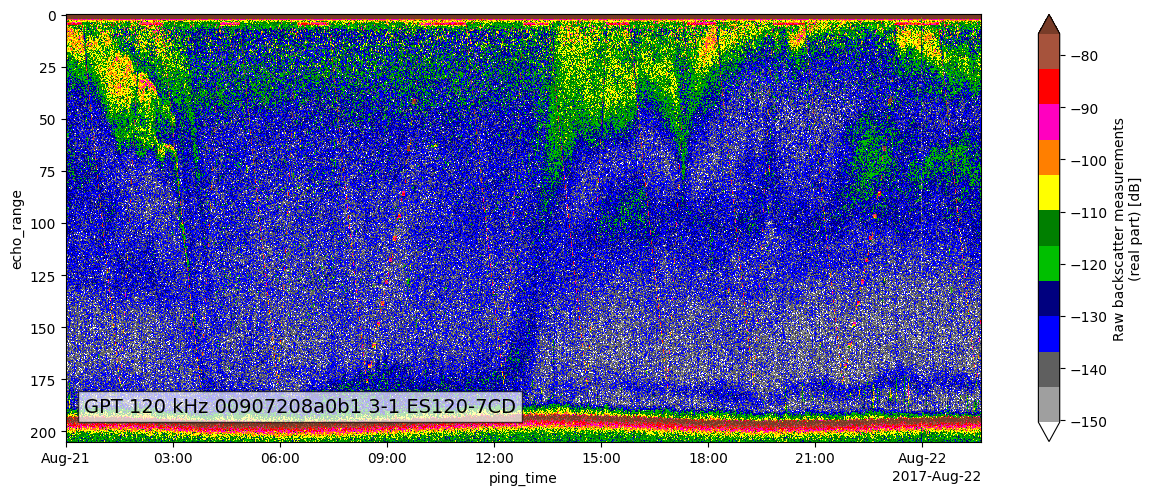

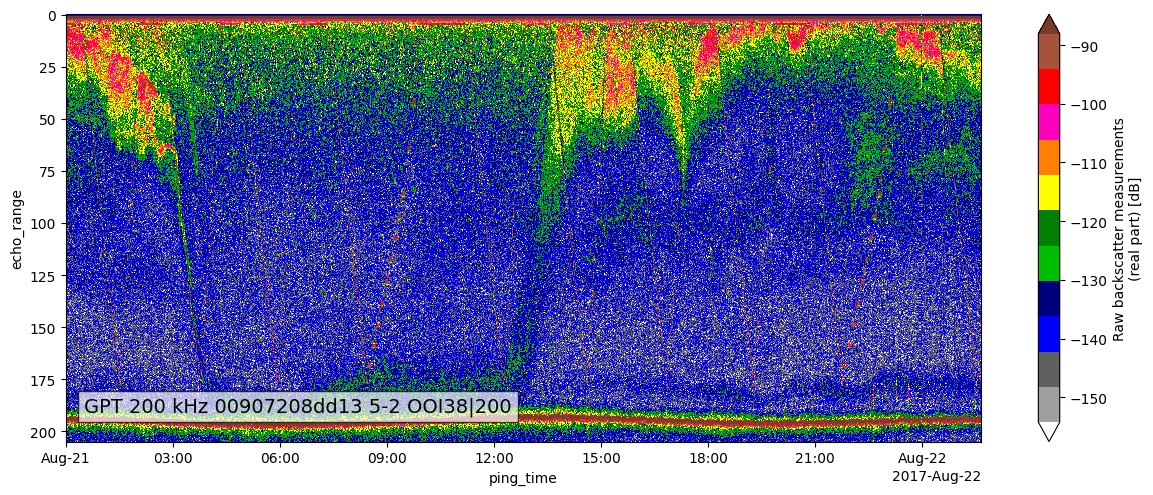

In [48]:
epviz.create_echogram(echodata, get_range=True, robust=True,cmap = 'ep.ek500')

In [ ]:
!pip install echopype[plot]

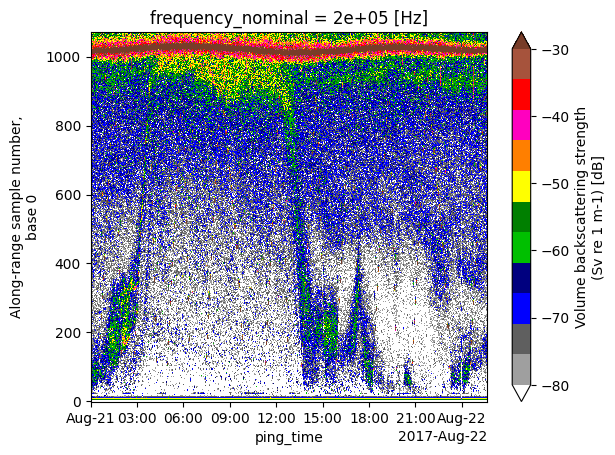

In [49]:
ds_Sv.Sv.sel(frequency_nominal=200000).plot.pcolormesh(
    x='ping_time', cmap = 'ep.ek500', vmin=-80, vmax=-30
);